In [1]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from datetime import date, timedelta
import time
from google.colab import drive
drive.mount('/content/drive')
!pip install sweetviz
import sweetviz as sv

Mounted at /content/drive
     |████████████████████████████████| 15.1MB 5.5MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_err2.csv')
train_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_qui2.csv')
train_prob = pd.read_csv('/content/drive/Shareddrives/dacon/404/train_prob2.csv')

test_err = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_err2.csv')
test_qui = pd.read_csv('/content/drive/Shareddrives/dacon/404/test_qui2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_qui2 = train_qui.copy()
test_qui2 = test_qui.copy()
train_err2 = train_err.copy()
test_err2 = test_err.copy()

# 퀼리티 3,4는 값이 1밖에 없어서 의미가 없기 때문에 제외
# 펌웨어 버전은 이미 err 자료에 있기 때문에 중복으로 제외
# 퀼리티 0은 EDA 결과 퀼리티 2와 피어슨 상관계수 0.99를 보이기 때문에 0과 2 중에 하나만 골랐음
# 0의 결측치 Nan은 15%고 2의 결측치는 4%기 때문에 결측치가 적은 2를 남기고 0은 drop 시킨다.

## 퀼리티 6과 7도 0.81로 강한 상관관계를 보이고 있는데, 하나를 제외해야 하나 고민이 됨
train_qui2.drop(['fwver','quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)
test_qui2.drop(['fwver', 'quality_0', 'quality_3', 'quality_4'], axis =1, inplace=True)

test_qui2 = test_qui2.replace(',','', regex=True)
train_qui2 = train_qui2.replace(',','', regex=True)
test_qui2.loc[:,'quality_1':'quality_12'] = test_qui2.loc[:,'quality_1':'quality_12'].astype(float)
train_qui2.loc[:,'quality_1':'quality_12'] = train_qui2.loc[:,'quality_1':'quality_12'].astype(float)

train_qui2['time'] = pd.to_datetime(train_qui['time'], format = '%Y-%m-%d %H:%M:%S')
test_qui2['time'] = pd.to_datetime(test_qui['time'], format = '%Y-%m-%d %H:%M:%S')

train_err2['time'] = pd.to_datetime(train_err2['time'], format = '%Y-%m-%d %H:%M:%S')
test_err2['time'] = pd.to_datetime(test_err2['time'], format = '%Y-%m-%d %H:%M:%S')
train_prob['time'] = pd.to_datetime(train_prob['time'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
# 퀼리티 임계치
# [-1, 0, 1] == -1 카테고리 -1, -1~0 =카테고리 0, 그 이상 = 카테고리 1
qualities = {}

qualities['quality_1'] = [-1,0, 1]
qualities['quality_2'] = [-1,0, 1]
qualities['quality_5'] = [-1,0,1,2,4, 10]
qualities['quality_6'] = [-1,0, 1]
qualities['quality_7'] = [0,1,100, 101]
qualities['quality_8'] = [0,1,2]
qualities['quality_9'] = [0,1,2]
qualities['quality_10'] = [0,1,2,3, 4, 5,7, 10 ,14,15] ##??
qualities['quality_11'] = [-1,0,1]
qualities['quality_12'] = [0,1,2]

## 모델 임계치
## 모델 0,1,2,3,4의 비율을 더하면 99.999% 이므로, 모델 5~8은 other model로 통합하는 것이 바람직 해 보임.

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
def quality_categorize(dataset):
  data = dataset.copy()
  for key in tqdm(qualities):
    intervals = qualities.get(key)
    for i in range(len(intervals)):
      if intervals[i] == intervals[-1]:
        data[key][data[key] >= intervals[i]] =  intervals[i]
      # elif intervals[i+1] - intervals[i] == 1:
      #   continue
      else:
        data[key][(data[key] >= intervals[i]) & (data[key] < intervals[i+1])] = intervals[i]
  return data


In [8]:
train_qui3 = quality_categorize(train_qui2)
test_qui3 = quality_categorize(test_qui2)

In [9]:
train_err2['err'] =  1
train_prob['err'] = 1

In [10]:
import random

User_id = 16089


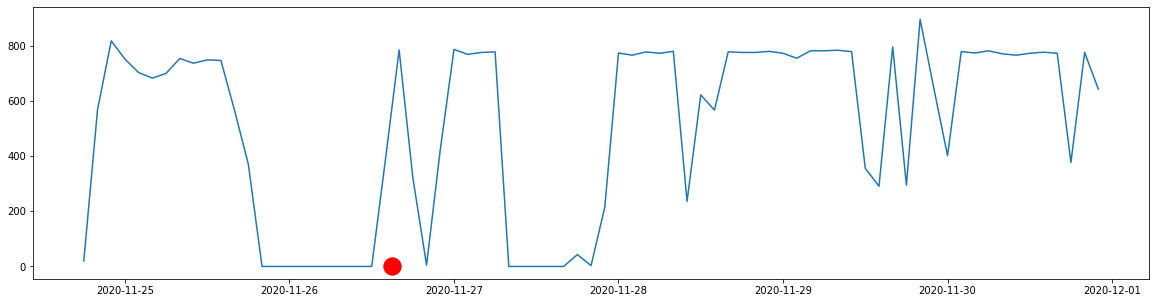

In [83]:
### 랜덤하게 한 명을 뽑아서 간격(interval)당 에러보고 횟수
## 빨간 점은 에러 리포트 시점! 없으면 에러 보고 안한 것

interval = '2h'  # 30분은 '30T', 4시간은 '4h' 등등
id = random.randint(10000,25000)
# err_type = 17
# temp = train_err2[train_err2.errtype == err_type]

temp = train_err2[train_err2['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '2h')).sum()
plt.figure(figsize=(20,5))
print('User_id = {}'.format(id))
plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)

# 12808, 12811, 13812
# 12810, 12812

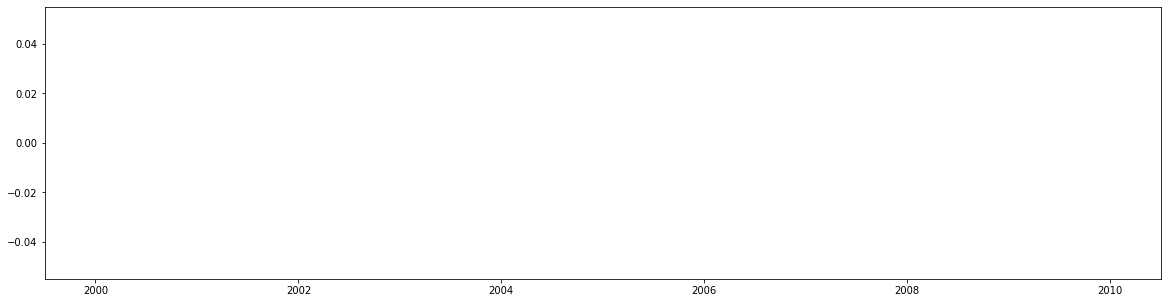

In [11]:
# 위의 버전에서 조금 업데이트
# err_type에 해당하는 에러들만 모아서 시간별 합계를 보여줌.

id = random.randint(10000,25000)
err_type = [10, 18,19,20,21,25, 34, 35]
# err_type = [17]
temp = train_err2[train_err2.errtype.isin(err_type)]

temp = temp[temp['user_id']==id]
prob = train_prob[train_prob.user_id == id]
temp_time = temp.groupby(pd.Grouper(key = 'time', freq = '2h')).sum()
plt.figure(figsize=(20,5))
plt.plot(temp_time.index, temp_time.err)
plt.scatter(prob.time, prob.err, c = 'red', s = 300)

In [12]:
k = train_err2[train_err2.errtype.isin(err_type)]
len(k.user_id.unique())

5747

In [45]:
def err_by_time(dataset, fr = '2h'):
  data = dataset.copy()
  ids = data.user_id.unique()
  ids.sort()
  time_list = []
  for id in tqdm(ids):
    temp = train_err2[train_err2['user_id']==id]
    prob = train_prob[train_prob.user_id == id]
    temp_time = temp.groupby(pd.Grouper(key = 'time', freq = fr)).sum()
    a = temp_time[['err']].mean().values[0]
    b = temp_time[['err']].std().values[0]
    time_list.append([a,b])
  df = pd.DataFrame(time_list, index = ids, columns = ['mean', 'std'])
  return df

In [46]:
temp = err_by_time(train_err2)

In [54]:
temp = temp.fillna(0)
prob_list = train_prob['user_id'].unique()
prob_list.sort()

In [59]:
temp = temp.reset_index()

In [62]:
temp['problems'] = temp['index'].isin(prob_list)
temp = temp.set_index('index')

In [77]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

temp.iloc[:,:2] = scaler.fit_transform(temp.iloc[:,:2])

In [78]:
temp_tr = temp[temp['problems']]
temp_fls = temp[temp['problems'] != True]

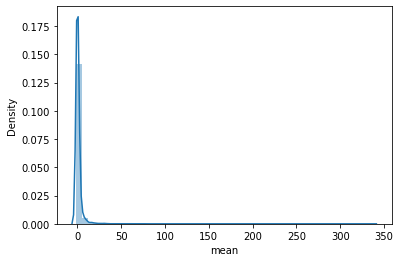

In [79]:
sns.distplot(temp_tr['mean'])

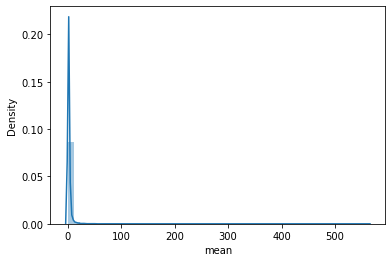

In [72]:
sns.distplot(temp_fls['mean'])

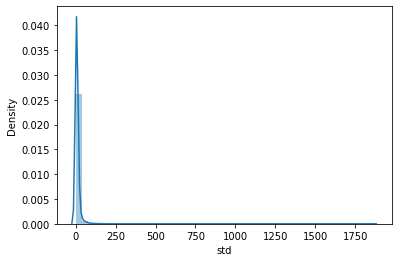

In [70]:
sns.distplot(temp_tr['std'])

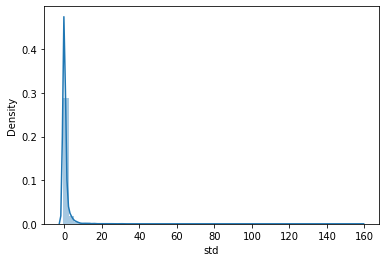

In [81]:
sns.distplot(temp_fls['std'])

In [71]:
temp_tr['std'].max()

1858.7845309261313

In [51]:
train_err3 = train_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]
test_err3 = test_err2[['user_id', 'model_nm', 'errtype', 'errcode', 'time']]

In [52]:
# 에러 코드의 분포는 다음과 같다.

print(train_err2.errcode.value_counts())
# 중간에 나오다가 잘리지만.. 전에 발간한 리포트를 보면 상위 15개 에러가 99.9%를 차지하고 있다.
# 따라서 상위 15개는 각각의 카테고리로 주고, 나머지는 16번째 '기타' 카테고리로 묶으면 어떨까 싶습니다.
# 상위 15개 리스트
err_code =['1','0','connection timeout','B-A8002','80','79','14','active','2','84','85','standby','NFANDROID2','connection fail to establish','3']

# 위의 15개에 포함되지 않는 에러코드는 걍 'etc'로 분류
train_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'
test_err3['errcode'][~train_err3['errcode'].isin(err_code)] = 'ETC'


## 에러타입은 어차피 41개 뿐이라... 분포도 고른 편 같고... 얌전히 두기로 함.

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
11534                       1
10420                       1
5396                        1
3185                        1
3776                        1
Name: errcode, Length: 2805, dtype: int64


In [53]:
train_err4 = train_err3.copy()

In [48]:
train_err4['hour'] = train_err4['time'].dt.hour
train_err4['weekday'] = train_err4['time'].dt.weekday

In [49]:
train_err4['problems'] = train_err4.user_id.isin(prob_list)
train_err4_tr = train_err4[train_err4['problems']]
train_err4_fls = train_err4[train_err4['problems'] != True]

In [56]:
tr = pd.DataFrame(train_err4_tr['errtype'].value_counts().sort_index())
all = pd.DataFrame(train_err4['errtype'].value_counts().sort_index())

In [78]:
tr.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
errtype,4016,9310,13940,363153,423956,28187,30025,28,54,96989,126391,132926,16363,125541,640140,513531,21257,2339,554,1809,506,964736,1250243,17646,1060,202030,294144,294513,281,868235,538238,69366,122748,7406,3860,3874,2349,8819,327526,48787,11905


In [60]:
k = tr/all
k.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42
errtype,0.186401,0.356623,0.453215,0.280049,0.444902,0.558357,0.577482,0.168675,0.495413,0.727038,0.411657,0.415159,0.716324,0.498149,0.398853,0.41103,0.462018,0.875702,0.834337,0.869712,0.833608,0.517185,0.549192,0.451639,0.89527,0.37664,0.543901,0.54108,0.699005,0.437333,0.476079,0.388655,0.741518,0.727005,0.414296,0.414953,0.517515,0.557459,0.448434,0.468484,0.346337
